## - Import

In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torch import autograd
from torch.autograd import Variable
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
from tqdm import tqdm
import math
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import argparse
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import os
import sys

/home/hoge/.local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import random
import numpy as np
import torch

def torch_fix_seed(seed=42):
    # Python random
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # Pytorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.use_deterministic_algorithms = True


torch_fix_seed()

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print('torch version:',torch.__version__)
print('device:', device)

torch version: 1.11.0+cu113
device: cuda


## - Parameters

In [4]:
img_size = 64 # Image size
batch_size = 16  # Batch size

# Model
z_size = 100
ngf = 32
ndf = 64
generator_layer_size = [256, 512, 1024, 2048]
discriminator_layer_size = [2048, 1024, 512, 256]

# Training
epochs = 100 # Train epochs
learning_rate_G_g = 2e-5
learning_rate_G_r = 5e-7
learning_rate_D = 1e-5

## - Pytorch Dataset, DataLoader: Fashion MNIST

In [5]:
class_list = [chr(i + 65) for i in range(26)]
class_num = len(class_list)

In [6]:
class ImageTransform():
  def __init__(self, mean, std):
    self.data_transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Resize((64, 64)),
    transforms.Normalize(mean, std)
    ])

  def __call__(self, img):
    return self.data_transform(img)

In [7]:
mean = (0.5,)
std = (0.5,)
images = ImageFolder( "../GoogleFonts/all", transform = ImageTransform(mean, std))
data_loader = DataLoader(images, batch_size = batch_size, shuffle = True, drop_last=True)

In [8]:
# print(dataset_GAN.X_train.shape)

# d = torch.from_numpy(dataset_GAN.X_train).float().clone()
# l = torch.from_numpy(dataset_GAN.y_train).long().clone()
# data_loader = zip(d, l)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


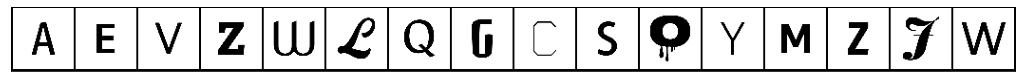

In [9]:
for images, labels in data_loader:
    fig, ax = plt.subplots(figsize=(18,10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=16).permute(1,2,0))
    break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


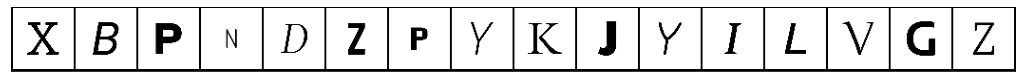

In [10]:
for images, labels in data_loader:
    fig, ax = plt.subplots(figsize=(18,10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=16).permute(1,2,0))
    break

In [11]:
def onehot_encode(label, n_class=26):  
    # ラベルをOne-Hoe形式に変換
    eye = torch.eye(n_class).to(device)
    # ランダムベクトルあるいは画像と連結するために(B, c_class, 1, 1)のTensorにして戻す
    return eye[label].view(-1, n_class, 1, 1)
    
def concat_image_label(image, label, n_class=26):
    # 画像とラベルを連結する
    oh_label = onehot_encode(label, n_class).to(device)       # ラベルをOne-Hot形式に変換
    oh_label = oh_label.expand(16, n_class, 64, 64)  # ラベルを画像サイズに拡大
    return torch.cat((image, oh_label), dim=1)    # 画像とラベルをチャネル方向（dim=1）で連結
 
def concat_noise_label(noise, label, n_class=26):
    # ランダムベクトルとラベルを連結する
    oh_label = onehot_encode(label, n_class).to(device)     # ラベルをOne-Hot形式に変換
    return torch.cat((noise, oh_label), dim=1)  # ランダムベクトルとラベルを連結

## - Generator

In [12]:
class Generator(nn.Module):
    def __init__(self, generator_layer_size, z_size, img_size, class_num):
        super().__init__()
        
        self.z_size = z_size
        self.img_size = img_size
        
        # self.label_emb = nn.Embedding(class_num, class_num)
        
        self.model = nn.Sequential(
            nn.ConvTranspose2d(self.z_size + 26, ngf * 32, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 32),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 32, ngf * 16, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 16),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 16, ngf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 2, ngf, 3, 1, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf, 1, 3, 1, 1, bias=False),
            nn.Tanh()
        )
    
    def forward(self, z, labels):

        x = concat_noise_label(z, labels)

        out = self.model(x)
        
        return out

## - Discriminator

In [13]:
class Discriminator(nn.Module):
    def __init__(self, discriminator_layer_size, img_size, class_num):
        super().__init__()
        
        # self.label_emb = nn.Embedding(class_num, class_num)
        self.img_size = img_size
        
        self.model = nn.Sequential(
            nn.Conv2d(27, ndf, 3, 1, 1, bias=False),
            nn.BatchNorm2d(ndf),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 2, 3, 1, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, ndf * 4, 3, 1, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 8, ndf * 8, 3, 1, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 8, 1, 8, 1, 0, bias=False),
            nn.Sigmoid()
        )
    
    def forward(self, x, labels):
        
        x = concat_image_label(x, labels)
        
        # Discriminator out
        out = self.model(x)
        
        return out.squeeze()

In [14]:
# Define generator
generator = Generator(generator_layer_size, z_size, img_size, class_num).to(device)
# Define discriminator
discriminator = Discriminator(discriminator_layer_size, img_size, class_num).to(device)

In [15]:
pretrained_model = "googlefonts.pth" #事前学習済みMNISTモデル(重みパラメータ)
class cNet(nn.Module):
    def __init__(self):
        super(cNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(57600, 128)
        self.fc2 = nn.Linear(128, 26)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

# ネットワークの初期化
cmodel = cNet().to(device)
print(cmodel)
# 訓練済みモデルのロード
cmodel.load_state_dict(torch.load(pretrained_model, map_location='cpu'))

# モデルを評価モードに設定。本チュートリアルの例では、これはドロップアウト層等を評価モードにするのに必要
cmodel.eval()

cNet(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=57600, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=26, bias=True)
)


cNet(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=57600, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=26, bias=True)
)

In [16]:
def attack(data, data_grad, target, epsilon, lim):
    for i in range(1, 1001):
        data.requires_grad = False
        sign_data_grad = data_grad.sign()
        perturbed_data = data + epsilon * sign_data_grad
        perturbed_data = torch.clamp(perturbed_data, -1, 1)
        data = perturbed_data
        data.requires_grad = True
        output = cmodel(data)
        loss = F.nll_loss(output, target)
        pred = output.max(1, keepdim=True)[1]
        if pred.item() != target.item():
            break
        cmodel.zero_grad()
        loss.backward()
        data_grad = data.grad.data
    return data, pred, i

In [17]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(57600, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        return x

## - Adversarial Learning of Generator & Discriminator

In [18]:
# Loss function
criterion = nn.BCELoss()
criterion_r = nn.MSELoss()

In [19]:
g_optimizer_g = torch.optim.Adam(generator.parameters(), lr=learning_rate_G_g)
g_optimizer_r = torch.optim.Adam(generator.parameters(), lr=learning_rate_G_r)
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=learning_rate_D)

In [20]:
def generator_train_step(batch_size, discriminator, generator, model_list, g_optimizer_g, g_optimizer_r, criterion, epoch):

    # Init gradient
    g_optimizer_g.zero_grad()
    g_optimizer_r.zero_grad()

    # Building z
    z = Variable(torch.randn(batch_size, z_size, 1, 1)).to(device)

    # Building fake labels
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, class_num, batch_size))).to(device)

    # Generating fake images
    fake_images = generator(z, fake_labels)

    # Disciminating fake images
    validity = discriminator(fake_images, fake_labels)

    # Calculating discrimination loss (fake images)
    g_loss = criterion(validity, Variable(torch.ones(batch_size)).to(device))

    r_l = 0
    for index, fale_label in enumerate(fake_labels):
        fake_image = fake_images[index].view(1, 1, 64, 64)
        output = model_list[fale_label](fake_image)
        r_l += criterion_r(output, torch.Tensor([[0]]).to(device))
    r_loss = 1 / (r_l / batch_size)

    

    # for index, fake_label in enumerate(fake_labels):
    #     fake_image = fake_images[index].view(1, 1, 64, 64)
    #     output = model_list[fake_label](fake_image)
    #     output_value = output.item() 
    #     if output_value > 20:
    #         output = output * 0 + 20
    #     r_l += (20 - output) ** 2
    # r_loss = r_l / batch_size

    # if epoch % 3 == 2:
    #     loss = g_loss
    #     # Backword propagation
    #     loss.backward()

    #     #  Optimizing generator
    #     g_optimizer_g.step()

    #     return loss.data.cpu(), g_loss.data.cpu(), r_loss.data.squeeze().squeeze().cpu()
        
    # else:
    loss = r_loss
        # Backword propagation
    loss.backward()

    #  Optimizing generator
    g_optimizer_r.step()

    return loss.squeeze().squeeze().data.cpu(), g_loss.data.cpu(), r_loss.squeeze().squeeze().data.cpu()

In [21]:
def discriminator_train_step(batch_size, discriminator, generator, d_optimizer, criterion, real_images, labels):
  # Init gradient 
  d_optimizer.zero_grad()

  # Disciminating real images
  real_validity = discriminator(real_images, labels)

  # Calculating discrimination loss (real images)
  real_loss = criterion(real_validity, Variable(torch.ones(batch_size)).to(device))

  # Building z
  z = Variable(torch.randn(batch_size, z_size, 1, 1)).to(device)

  # Building fake labels
  fake_labels = Variable(torch.LongTensor(np.random.randint(0, class_num, batch_size))).to(device)

  # Generating fake images
  fake_images = generator(z, fake_labels)

  # Disciminating fake images
  fake_validity = discriminator(fake_images, fake_labels)

  # Calculating discrimination loss (fake images)
  fake_loss = criterion(fake_validity, Variable(torch.zeros(batch_size)).to(device))

  # Sum two losses
  loss = real_loss + fake_loss

  # Backword propagation
  loss.backward()

  # Optimizing discriminator
  d_optimizer.step()

  return loss.data.cpu()

In [22]:
def train(model, device, images, labels, optimizer, epoch):
    criterion = torch.nn.MSELoss()
    model.train()
    for batch_idx, (data, target) in enumerate(zip(images, labels)):
        # if batch_idx != 0 and batch_idx != 100:
        #     continue
        data, target = data.to(device, dtype=torch.float), target.to(device, dtype=torch.float)
        # print(target)
        # target = target.type(torch.LongTensor)
        # data = (data >= torch.Tensor([0]).to("cpu")).float() - (data < torch.Tensor([0]).to("cpu")).float()
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        # if batch_idx % 10 == 0:
        #     print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        #         epoch, batch_idx * len(data), len(data) * len(images),
        #         100. * batch_idx / len(images), loss.item()))

In [23]:
def test(model, device, images, labels):
    criterion = torch.nn.MSELoss()
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(zip(images, labels)):
            # if batch_idx != 200 and batch_idx != 400:
            #     continue
            data, target = data.to(device), target.to(device)
            # print(target)
            # data = (data >= torch.Tensor([0]).to("cpu")).float() - (data < torch.Tensor([0]).to("cpu")).float()
            output = model(data)
            test_loss += criterion(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /=len(images)

    # print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    #     test_loss, correct, len(images),
    #     100. * correct / (16 * len(images))))
    
    return test_loss

In [24]:
class EarlyStopping:
    """earlystoppingクラス"""

    def __init__(self, patience=5, verbose=False, path='../GAN+attack/model/reg_A.pth'):
        """引数：最小値の非更新数カウンタ、表示設定、モデル格納path"""

        self.patience = patience    #設定ストップカウンタ
        self.verbose = verbose      #表示の有無
        self.counter = 0            #現在のカウンタ値
        self.best_score = None      #ベストスコア
        self.early_stop = False     #ストップフラグ
        self.val_loss_min = np.Inf   #前回のベストスコア記憶用
        self.path = path             #ベストモデル格納path

    def __call__(self, val_loss, model):
        """
        特殊(call)メソッド
        実際に学習ループ内で最小lossを更新したか否かを計算させる部分
        """
        score = -val_loss

        if self.best_score is None:  #1Epoch目の処理
            self.best_score = score   #1Epoch目はそのままベストスコアとして記録する
            self.checkpoint(val_loss, model)  #記録後にモデルを保存してスコア表示する
        elif score < self.best_score:  # ベストスコアを更新できなかった場合
            self.counter += 1   #ストップカウンタを+1
            # if self.verbose:  #表示を有効にした場合は経過を表示
            #     print(f'EarlyStopping counter: {self.counter} out of {self.patience}')  #現在のカウンタを表示する 
            if self.counter >= self.patience:  #設定カウントを上回ったらストップフラグをTrueに変更
                self.early_stop = True
        else:  #ベストスコアを更新した場合
            self.best_score = score  #ベストスコアを上書き
            self.checkpoint(val_loss, model)  #モデルを保存してスコア表示
            self.counter = 0  #ストップカウンタリセット

    def checkpoint(self, val_loss, model):
        '''ベストスコア更新時に実行されるチェックポイント関数'''
        # if self.verbose:  #表示を有効にした場合は、前回のベストスコアからどれだけ更新したか？を表示
        #     print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)  #ベストモデルを指定したpathに保存
        self.val_loss_min = val_loss  #その時のlossを記録する

In [25]:
def regressor_train_step(Epoch):
    print("epoch {}".format(Epoch))
    for alphabet in range(26):
        print(chr(alphabet + 65))
        # # Training settings
        # parser = argparse.ArgumentParser(description='PyTorch MNIST Example')
        # parser.add_argument('--batch-size', type=int, default=64, metavar='N',
        #                     help='input batch size for training (default: 64)')
        # parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
        #                     help='input batch size for testing (default: 1000)')
        # parser.add_argument('--epochs', type=int, default=14, metavar='N',
        #                     help='number of epochs to train (default: 14)')
        # parser.add_argument('--lr', type=float, default=1.0, metavar='LR',
        #                     help='learning rate (default: 1.0)')
        # parser.add_argument('--gamma', type=float, default=0.7, metavar='M',
        #                     help='Learning rate step gamma (default: 0.7)')
        # parser.add_argument('--no-cuda', action='store_true', default=False,
        #                     help='disables CUDA training')
        # parser.add_argument('--dry-run', action='store_true', default=False,
        #                     help='quickly check a single pass')
        # parser.add_argument('--seed', type=int, default=1, metavar='S',
        #                     help='random seed (default: 1)')
        # parser.add_argument('--log-interval', type=int, default=10, metavar='N',
        #                     help='how many batches to wait before logging training status')
        # parser.add_argument('--save-model', action='store_true', default=True,
        #                     help='For Saving the current Model')
        # args = parser.parse_args()
        # use_cuda = not args.no_cuda and torch.cuda.is_available()

        # torch.manual_seed(args.seed)

        # device = torch.device("cuda" if use_cuda else "cpu")

        # train_kwargs = {'batch_size': args.batch_size}
        # test_kwargs = {'batch_size': args.test_batch_size}
        # if use_cuda:
        #     cuda_kwargs = {'num_workers': 1,
        #                 'pin_memory': True,
        #                 'shuffle': True}
        #     train_kwargs.update(cuda_kwargs)
        #     test_kwargs.update(cuda_kwargs)

        if Epoch == 1:
            generator.load_state_dict(torch.load("generator.pth", map_location='cpu'))
            discriminator.load_state_dict(torch.load("discriminator.pth", map_location='cpu'))
            
        
        z = Variable(torch.randn(4000, z_size, 1, 1)).to(device)
        labels = Variable(torch.LongTensor(np.zeros(4000) + alphabet)).to(device)
        GAN_images = generator(z, labels).data.to("cpu")
        train_val_images = []
        rlabels = []
        batch_count = 0
        mean = []

        for data, target in tqdm(zip(GAN_images, labels), total = 4000):
            if batch_count % 16 == 0:
                image_batch_list = []
                rlabel_batch_list = []
                batch_count = 0
            # データとラベルをデバイス（CPUもしくはGPU）に送信します
            data1, target1 = data.unsqueeze(0).to(device), target.unsqueeze(0).type(torch.LongTensor).to(device)
            
            # テンソルの requires_grad 属性を設定します。攻撃者にとっては重要な設定です。

            data1.requires_grad = True

            # データをモデルに順伝播させます
            output = cmodel(data1)
            init_pred = output.max(1, keepdim=True)[1] # 最大の確率のインデックスを取得します。

            # 最初から予測が間違っている場合、攻撃する必要がないため次のイテレーションに進みます。
            
            if init_pred.item() != target1.item():
                
                continue
            
            data_copy = data1.detach().clone()

            # 損失を計算します
            loss = F.nll_loss(output, target1)
            # 既存の勾配を全てゼロにします
            cmodel.zero_grad()
            # 逆伝播させてモデルの勾配を計算します
            loss.backward()
            # データの勾配を取得します
            data_grad = data1.grad.data

            perturbed_data, pred, resistance = attack(data1, data_grad, target1, 0.02, 0)
            
            image_batch_list.append(data)
            rlabel_batch_list.append(resistance)

            batch_count += 1
            

            if batch_count == 16:
                mean.append(np.mean(rlabel_batch_list))
                image_batch_list = torch.stack(image_batch_list, dim=0).to(device)
                rlabel_batch_list = torch.tensor(rlabel_batch_list).to(device)
                train_val_images.append(image_batch_list)
                rlabels.append(rlabel_batch_list)

            if len(train_val_images) == 125:
                print("mean:{}".format(np.mean(mean)))
                break

        else:
            print(len(train_val_images))
            print("stop")
            sys.exit()
        
        train_val_images = torch.stack(train_val_images, dim=0).to(device)
        rlabels = torch.stack(rlabels, dim=0).to(device)

        train_images, val_images = train_test_split(train_val_images, shuffle=False)
        train_rlabels, val_rlabels = train_test_split(rlabels, shuffle=False)
 

        model = Net().to(device)
        optimizer = optim.Adadelta(model.parameters(), lr=1.0)

        scheduler = StepLR(optimizer, step_size=1, gamma=0.7)

        os.makedirs("../GAN+attack_r_only_max/rmodel/{}".format(Epoch), exist_ok=True)
            
        #★EarlyStoppingクラスのインスタンス化★
        earlystopping = EarlyStopping(patience=10, verbose=True, path="../GAN+attack_r_only_max/rmodel/{}/reg_".format(Epoch) + chr(alphabet + 65) + ".pth")

        # for epoch in range(1, args.epochs + 1):
        for epoch in range(1, 1000):
            train(model, device, train_images, train_rlabels, optimizer, epoch)
            test_loss =  test(model, device, val_images, val_rlabels)
            #★毎エポックearlystoppingの判定をさせる★
            earlystopping(test_loss, model) #callメソッド呼び出し
            if earlystopping.early_stop: #ストップフラグがTrueの場合、breakでforループを抜ける
                # print("Early Stopping!")
                break
            scheduler.step()

Starting epoch 1...
epoch 1
A


 50%|█████     | 2008/4000 [02:43<02:42, 12.28it/s]
/home/hoge/.local/lib/python3.9/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


mean:21.677
B


 52%|█████▏    | 2098/4000 [01:22<01:14, 25.58it/s]


mean:14.7515
C


 52%|█████▏    | 2060/4000 [01:32<01:27, 22.26it/s]


mean:16.9335
D


 51%|█████▏    | 2057/4000 [01:34<01:28, 21.85it/s]


mean:16.854
E


 54%|█████▍    | 2175/4000 [01:17<01:05, 27.98it/s]


mean:14.0155
F


 51%|█████     | 2035/4000 [01:43<01:39, 19.75it/s]


mean:19.031
G


 51%|█████     | 2041/4000 [01:36<01:32, 21.21it/s]


mean:17.8195
H


 52%|█████▏    | 2094/4000 [01:56<01:46, 17.95it/s]


mean:21.2565
I


 52%|█████▏    | 2087/4000 [01:34<01:26, 22.00it/s]


mean:17.3375
J


 53%|█████▎    | 2134/4000 [01:42<01:29, 20.82it/s]


mean:18.6905
K


 50%|█████     | 2017/4000 [01:49<01:47, 18.42it/s]


mean:19.925
L


 50%|█████     | 2019/4000 [01:55<01:53, 17.43it/s]


mean:21.0555
M


 52%|█████▏    | 2076/4000 [01:21<01:15, 25.34it/s]


mean:14.349
N


 51%|█████     | 2033/4000 [01:41<01:38, 19.94it/s]


mean:18.879
O


 50%|█████     | 2012/4000 [01:27<01:26, 23.01it/s]


mean:15.2
P


 50%|█████     | 2010/4000 [01:59<01:58, 16.76it/s]


mean:18.005
Q


 57%|█████▋    | 2264/4000 [01:34<01:12, 23.91it/s]


mean:16.507
R


 52%|█████▏    | 2066/4000 [01:25<01:20, 24.14it/s]


mean:15.5025
S


 51%|█████     | 2041/4000 [01:37<01:33, 20.96it/s]


mean:17.8585
T


 51%|█████     | 2041/4000 [01:33<01:29, 21.79it/s]


mean:16.6435
U


 52%|█████▏    | 2066/4000 [01:31<01:25, 22.60it/s]


mean:16.6125
V


 51%|█████     | 2047/4000 [01:39<01:34, 20.59it/s]


mean:16.89
W


 51%|█████     | 2029/4000 [01:37<01:35, 20.74it/s]


mean:16.9
X


 50%|█████     | 2010/4000 [01:24<01:23, 23.71it/s]


mean:14.4575
Y


 50%|█████     | 2015/4000 [02:22<02:20, 14.13it/s]


mean:17.421
Z


 52%|█████▏    | 2062/4000 [03:00<02:49, 11.40it/s]


mean:20.4025


100%|██████████| 4116/4116 [07:51<00:00,  8.73it/s]


G_loss: 0.00351068377494812, D_loss: 0.006246638484299183, g_loss: 13.68664264678955, r_loss: 0.00351068377494812


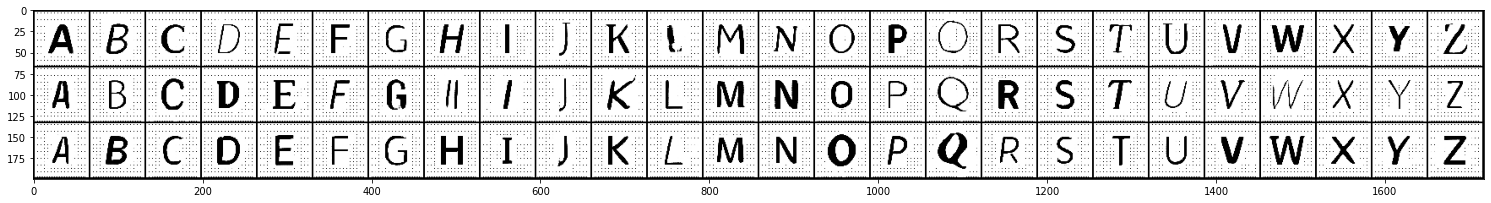

Starting epoch 2...
epoch 2
A


 51%|█████     | 2021/4000 [01:20<01:19, 25.00it/s]


mean:14.0925
B


 51%|█████     | 2040/4000 [01:02<01:00, 32.54it/s]


mean:10.899
C


 51%|█████     | 2026/4000 [01:07<01:05, 29.97it/s]


mean:11.055
D


 50%|█████     | 2014/4000 [01:24<01:23, 23.90it/s]


mean:15.0145
E


 54%|█████▍    | 2179/4000 [00:35<00:29, 60.93it/s]


mean:6.274
F


 52%|█████▏    | 2071/4000 [01:07<01:02, 30.89it/s]


mean:12.0975
G


 52%|█████▏    | 2074/4000 [01:13<01:07, 28.33it/s]


mean:13.17
H


 53%|█████▎    | 2105/4000 [01:25<01:16, 24.76it/s]


mean:15.3165
I


 64%|██████▍   | 2564/4000 [00:39<00:22, 64.95it/s]


mean:6.644
J


 54%|█████▎    | 2144/4000 [00:50<00:43, 42.24it/s]


mean:8.689
K


 50%|█████     | 2000/4000 [01:27<01:27, 22.84it/s]


mean:15.742
L


 50%|█████     | 2004/4000 [00:58<00:57, 34.43it/s]


mean:10.081
M


 50%|████▉     | 1999/4000 [01:37<01:38, 20.41it/s]


mean:17.36
N


 50%|████▉     | 1999/4000 [01:29<01:29, 22.30it/s]


mean:16.215
O


 50%|█████     | 2004/4000 [01:19<01:18, 25.32it/s]


mean:12.01
P


 50%|████▉     | 1999/4000 [01:26<01:26, 23.05it/s]


mean:15.6225
Q


 54%|█████▎    | 2148/4000 [01:21<01:10, 26.42it/s]


mean:14.76
R


 51%|█████     | 2025/4000 [01:28<01:26, 22.85it/s]


mean:14.5285
S


 50%|█████     | 2002/4000 [01:34<01:34, 21.09it/s]


mean:16.403
T


 50%|█████     | 2011/4000 [01:14<01:13, 27.08it/s]


mean:13.3215
U


 50%|█████     | 2008/4000 [01:08<01:07, 29.48it/s]


mean:12.5715
V


 51%|█████     | 2021/4000 [00:38<00:37, 52.24it/s]


mean:6.9175
W


 50%|█████     | 2003/4000 [01:36<01:36, 20.66it/s]


mean:18.125
X


 50%|█████     | 2005/4000 [01:06<01:06, 30.12it/s]


mean:11.658
Y


 50%|█████     | 2013/4000 [01:06<01:05, 30.47it/s]


mean:11.049
Z


 50%|█████     | 2010/4000 [01:28<01:27, 22.78it/s]


mean:16.268


100%|██████████| 4116/4116 [06:43<00:00, 10.19it/s]


G_loss: 0.005922831129282713, D_loss: 5.769659765064716e-06, g_loss: 16.660737991333008, r_loss: 0.005922831129282713


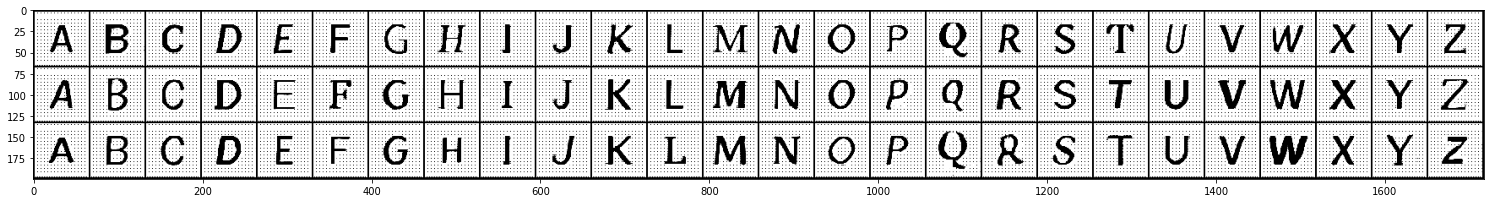

Starting epoch 3...
epoch 3
A


 50%|█████     | 2004/4000 [00:55<00:55, 35.90it/s]


mean:9.7485
B


 50%|█████     | 2019/4000 [00:49<00:48, 41.19it/s]


mean:8.718
C


 50%|█████     | 2019/4000 [00:36<00:35, 55.72it/s]


mean:6.2445
D


 50%|█████     | 2005/4000 [01:01<01:01, 32.63it/s]


mean:8.8315
E


 53%|█████▎    | 2131/4000 [00:29<00:25, 72.80it/s]


mean:5.0805
F


 50%|█████     | 2012/4000 [00:59<00:59, 33.54it/s]


mean:10.3325
G


 50%|█████     | 2008/4000 [01:00<00:59, 33.39it/s]


mean:10.798
H


 51%|█████▏    | 2058/4000 [01:02<00:58, 33.08it/s]


mean:11.0375
I


100%|██████████| 4000/4000 [00:17<00:00, 223.19it/s]

108
stop


SystemExit: 

/home/hoge/.local/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3406: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [26]:
history = []
for epoch in range(epochs):
    print('Starting epoch {}...'.format(epoch+1))
    G_losses, D_losses, g_losses, r_losses = [], [], [], []
    regressor_train_step(epoch + 1)
    # 使うデバイス（CPUかGPUか）の定義
    model_list = []
    for i in range(26):
        pretrained_model = "../GAN+attack_r_only_max/rmodel/{}/reg_".format(epoch + 1) + chr(i + 65) + ".pth"
        # ネットワークの初期化
        model = Net().to(device)
        # 訓練済みモデルのロード
        model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))
        # モデルを評価モードに設定。本チュートリアルの例では、これはドロップアウト層等を評価モードにするのに必要
        model.eval()
        model_list.append(model)
    for images, labels in tqdm(data_loader):
        # Train data
        real_images = Variable(images).to(device)
        labels = Variable(labels).to(device)

        # Set generator train
        generator.train()

        # Train discriminator
        d_loss = discriminator_train_step(len(real_images), discriminator,
                                          generator, d_optimizer, criterion,
                                          real_images, labels)
        
        # Train generator
        G_loss, g_loss, r_loss = generator_train_step(batch_size, discriminator, generator, model_list, g_optimizer_g, g_optimizer_r, criterion, epoch)

        G_losses.append(G_loss)
        D_losses.append(d_loss)
        g_losses.append(g_loss)
        r_losses.append(r_loss)
    
   
    info = {
            "epoch": epoch + 1,
            "G_loss": np.mean(G_losses),
            "D_loss": np.mean(D_losses),
            "g_loss": np.mean(g_losses),
            "r_loss": np.mean(r_losses),
            }
    history.append(info)
    torch.save(generator.state_dict(), "../GAN+attack_r_only_max/model/{}.pth".format(epoch + 1))

    # Set generator eval
    generator.eval()
    print('G_loss: {}, D_loss: {}, g_loss: {}, r_loss: {}'.format(np.mean(G_losses), np.mean(D_losses), np.mean(g_losses), np.mean(r_losses)))
    
    z = Variable(torch.randn(3 * 26, z_size, 1, 1)).to(device)

    # Labels 0 ~ 9
    labels = Variable(torch.LongTensor([i for _ in range(3) for i in range(class_num)])).to(device)

    # Generating images
    sample_images = generator(z, labels)

    sample_images = sample_images.data.cpu()
    grid = make_grid(sample_images, nrow=26, normalize=True).permute(1,2,0).numpy()
    fig, ax = plt.subplots(figsize=(26,26))
    plt.imshow(grid)
    plt.savefig("../GAN+attack_r_only_max/sample/{}.png".format(epoch + 1))
    plt.show()

history = pd.DataFrame(history)

In [ ]:
fig, ax = plt.subplots()
# 損失の推移を描画する。
# ax.plot(history["epoch"], history["G_loss"], label="Generator")
ax.plot(history["epoch"], history["g_loss"], label="Generator_g")
ax.plot(history["epoch"], history["r_loss"], label="Generator_r")
ax.plot(history["epoch"], history["D_loss"], label="Discriminator")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.legend()
plt.show()
fig.savefig("../GAN+attack_r_only_max/loss/loss.png", facecolor="white")

In [ ]:
plt.plot(history["epoch"], history["D_loss"], color='#ff7f00',label="Discriminator")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig("../GAN+attack_r_only_max/loss/d_loss.png", facecolor="white")
plt.show()

## - Show Generating Images

In [ ]:
for i in range(1, 101):    
    z = Variable(torch.randn(26 * 26, z_size, 1, 1)).to(device)

    # Labels 0 ~ 9
    labels = Variable(torch.LongTensor([i for _ in range(class_num) for i in range(class_num)])).to(device)

    generator.load_state_dict(torch.load("../GAN+attack_r_only_max/model/{}.pth".format(i), map_location='cpu'))

    # Generating images
    sample_images = generator(z, labels)

    reg_list = []
    false = 0
    for image, label in zip(sample_images, labels):
        image, label = image.unsqueeze(0).to(device), label.unsqueeze(0).type(torch.LongTensor).to(device)

        # データをモデルに順伝播させます
        output = cmodel(image)
        init_pred = output.max(1, keepdim=True)[1] # 最大の確率のインデックスを取得します。

        # 最初から予測が間違っている場合、攻撃する必要がないため次のイテレーションに進みます。
        
        if init_pred.item() != label.item():
            false += 1
            continue

        reg_list.append(model_list[label.item()](image).item())

        if len(reg_list) == 500:
            break

    # print(reg_list)
    print("{}:{}".format(i, np.mean(reg_list)))